# Expanded Fruits-360 - DeiT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/'Applied CV Project'/fruits-360_dataset

/content/drive/.shortcut-targets-by-id/1i0IgUBpr8uyXxhLQgE5RaQK7Qf6agpOh/Applied CV Project/fruits-360_dataset


In [3]:
ls

AdditionalFoodItems/  fruits-360/  fruits-360.zip


In [4]:
!mkdir -p ~/.data
!cp "fruits-360.zip" ~/.data/
!chmod 600 ~/.data/"fruits-360.zip"
!ls ~/.data

fruits-360.zip


In [5]:
import os, shutil
import zipfile

zip_file_path = './fruits-360.zip'
assert os.path.exists(zip_file_path)

# extract all files to /tmp
print('Source zip: %s' % zip_file_path)
print('Extracting all images...', end='', flush=True)
zip_ref = zipfile.ZipFile(zip_file_path, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()
print('done!', flush=True)

Source zip: ./fruits-360.zip
Extracting all images...done!


In [6]:
def get_fruit_categories(folder_root):
    """
    Get the fruit categories from the provided folder root.

    Args:
    - folder_root (str): The root folder containing the fruit categories.

    Returns:
    - fruit_categories (dict): A dictionary mapping category indices to category names.
    """
    fruit_category_names = sorted(os.listdir(folder_root))
    fruit_categories = {i: name for i, name in enumerate(fruit_category_names)}
    return fruit_categories

In [7]:
!ls '/tmp/fruits-360'

 LICENSE	  readme.md		    Test_data.json	   Training_data_april_11.json
'Original Size'   Test			    test-multiple_fruits   Training_data.json
 papers		  Test_data_april_11.json   Training		   Training_data_updated.json


In [8]:
!ls '/tmp/fruits-360/Training'

'Apple Braeburn'        Clementine	   'Mango Red'		  Pineapple
'Apple Crimson Snow'    Cocos		    Mangostan		 'Pineapple Mini'
'Apple Golden 1'        Corn		    Maracuja		 'Pitahaya Red'
'Apple Golden 2'       'Corn Husk'	   'Melon Piel de Sapo'   Plum
'Apple Golden 3'       'Cucumber Ripe'	    Milk		 'Plum 2'
'Apple Granny Smith'   'Cucumber Ripe 2'    Mulberry		 'Plum 3'
'Apple Pink Lady'       Dates		    Nectarine		  Pomegranate
'Apple Red 1'	        Egg		   'Nectarine Flat'	 'Pomelo Sweetie'
'Apple Red 2'	        Eggplant	   'Nut Forest'		  Pork
'Apple Red 3'	        Eggs		   'Nut Pecan'		 'Potato Red'
'Apple Red Delicious'   Fig		   'Onion Red'		 'Potato Red Washed'
'Apple Red Yellow 1'    Flour		   'Onion Red Peeled'	 'Potato Sweet'
'Apple Red Yellow 2'   'Ginger Root'	   'Onion White'	 'Potato White'
 Apricot	        Granadilla	    Orange		  Quince
 Avocado	       'Grape Blue'	    Papaya		  Rambutan
'Avocado ripe'	       'Grapefruit Pink'   'Passion Fruit'	  Raspberry
 Banana		 

In [9]:
!ls '/tmp/fruits-360/Test'

'Apple Braeburn'        Clementine	   'Mango Red'		  Pineapple
'Apple Crimson Snow'    Cocos		    Mangostan		 'Pineapple Mini'
'Apple Golden 1'        Corn		    Maracuja		 'Pitahaya Red'
'Apple Golden 2'       'Corn Husk'	   'Melon Piel de Sapo'   Plum
'Apple Golden 3'       'Cucumber Ripe'	    Milk		 'Plum 2'
'Apple Granny Smith'   'Cucumber Ripe 2'    Mulberry		 'Plum 3'
'Apple Pink Lady'       Dates		    Nectarine		  Pomegranate
'Apple Red 1'	        Egg		   'Nectarine Flat'	 'Pomelo Sweetie'
'Apple Red 2'	        Eggplant	   'Nut Forest'		  Pork
'Apple Red 3'	        Eggs		   'Nut Pecan'		 'Potato Red'
'Apple Red Delicious'   Fig		   'Onion Red'		 'Potato Red Washed'
'Apple Red Yellow 1'    Flour		   'Onion Red Peeled'	 'Potato Sweet'
'Apple Red Yellow 2'   'Ginger Root'	   'Onion White'	 'Potato White'
 Apricot	        Granadilla	    Orange		  Quince
 Avocado	       'Grape Blue'	    Papaya		  Rambutan
'Avocado ripe'	       'Grapefruit Pink'   'Passion Fruit'	  Raspberry
 Banana		 

In [10]:
# Specify folder roots
train_folder_root = '/tmp/fruits-360/Training'
test_folder_root = '/tmp/fruits-360/Test'

train_classes = get_fruit_categories(train_folder_root)
val_classes = get_fruit_categories(test_folder_root)

In [11]:
# Check if both dictionaries have the same keys
if train_classes.keys() != val_classes.keys():
    print("The dictionaries have different keys:")
    print("Keys in train_classes:", train_classes.keys())
    print("Keys in val_classes:", val_classes.keys())
else:
    print("The dictionaries have the same keys.")

# Check if the values for each key are the same
differences = {}
for key in train_classes:
    if train_classes[key] != val_classes[key]:
        differences[key] = (train_classes[key], val_classes[key])

if differences:
    print("\nKey-value mappings with differences:")
    for key, (train_value, val_value) in differences.items():
        print(f"Key: {key}, train_value: {train_value}, val_value: {val_value}")
else:
    print("\nBoth dictionaries have identical key-value mappings.")

The dictionaries have the same keys.

Both dictionaries have identical key-value mappings.


In [15]:
assert(len(train_classes.keys()) == len(val_classes.keys()))
NUM_CLASSES = len(train_classes.keys())
print('Detected %d classes' % NUM_CLASSES)

Detected 143 classes


In [16]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 2.2.1+cu121 _CudaDeviceProperties(name='NVIDIA A100-SXM4-40GB', major=8, minor=0, total_memory=40513MB, multi_processor_count=108)


In [17]:
# Scale all images to same size, convert them to tensors, and normalize data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
train_dataset = ImageFolder(train_folder_root, train_transforms)
val_dataset = ImageFolder(test_folder_root, val_transforms)

print("No of training records: %d" % len(train_dataset))
print("No of test records: %d" % len(val_dataset))

No of training records: 69167
No of test records: 23015


In [19]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

print(len(train_loader))
print(len(val_loader))

1081
360


In [20]:
# Define a function to display images
def show_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(torch.transpose(images[i], 0, 2).numpy())
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.suptitle(title, fontsize=16)
    plt.show()

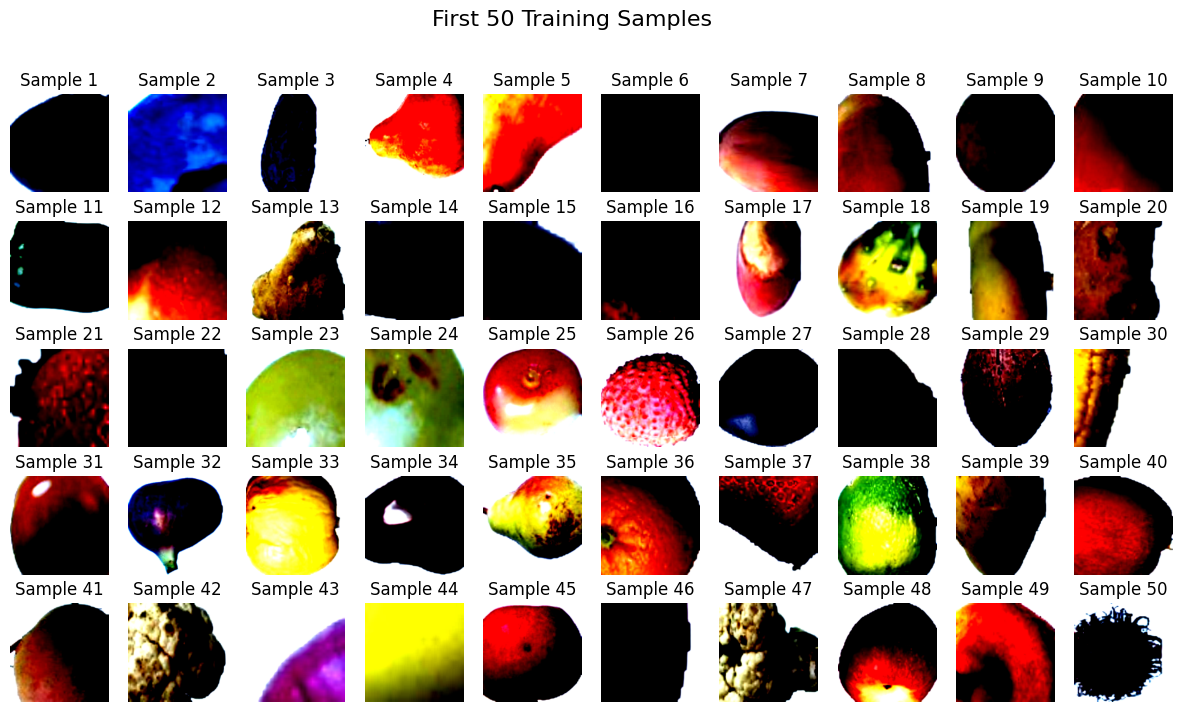

In [21]:
# Display first 50 samples from train_loader
train_iterator = iter(train_loader)
train_images, _ = next(train_iterator)
show_images(train_images[:50], title='First 50 Training Samples')

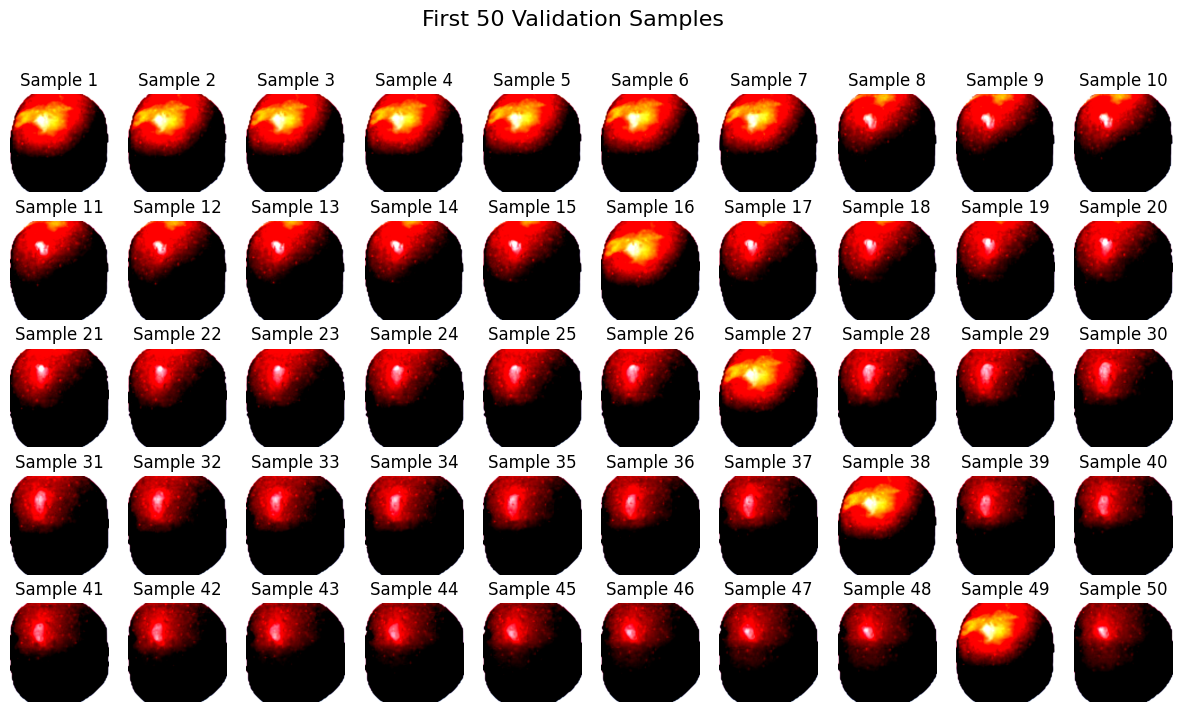

In [22]:
# Display first 50 samples from val_loader
val_iterator = iter(val_loader)
val_images, _ = next(val_iterator)
show_images(val_images[:50], title='First 50 Validation Samples')

## Using Pre-Trained DeiT Model

In [23]:
from transformers import DeiTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class DeiTForImageClassification(nn.Module):
    def __init__(self, num_labels=NUM_CLASSES):
        super(DeiTForImageClassification, self).__init__()
        self.deit = DeiTModel.from_pretrained('facebook/deit-base-distilled-patch16-224')

        self.classifier = nn.Sequential(
            nn.Linear(self.deit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256, NUM_CLASSES)
        )
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.deit(pixel_values=pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:,0])
        return logits

In [24]:
net = DeiTForImageClassification()
print(net)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in

In [25]:
def train_model(model, train_loader, val_loader, lr, epochs, momentum, weight_decay, patience, n_epochs_stop):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)

    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    y_testing = []
    preds = []

    min_val_loss = np.Inf
    epochs_no_improv = 0

    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')

    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)

                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())

                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]

                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')

            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)

            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

            if mode == 'val':
                # Check validation loss for early stopping
                if epoch_loss < min_val_loss:
                    torch.save(model.state_dict(), 'best_additional_deit.pth')
                    epochs_no_improv = 0
                    min_val_loss = epoch_loss
                else:
                    epochs_no_improv += 1
                    print(f'Epochs with no improvement {epochs_no_improv}')
                    if epochs_no_improv == n_epochs_stop:
                        print('Early stopping!')
                        return model, (losses, accuracies), y_testing, preds
                    model.load_state_dict(torch.load('best_additional_deit.pth'))

                scheduler.step(epoch_loss)

    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

In [26]:
learning_rate = 0.001
epochs = 3
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(net, train_loader, val_loader,
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using 1 GPUs
[train] Epoch 1/3 Iteration 1/1081 Loss: 4.98 Accuracy: 0.02
[train] Epoch 1/3 Iteration 217/1081 Loss: 2.64 Accuracy: 0.32
[train] Epoch 1/3 Iteration 433/1081 Loss: 1.80 Accuracy: 0.51
[train] Epoch 1/3 Iteration 649/1081 Loss: 1.41 Accuracy: 0.61
[train] Epoch 1/3 Iteration 865/1081 Loss: 1.18 Accuracy: 0.67
[train] Epoch 1/3 Iteration 1081/1081 Loss: 1.03 Accuracy: 0.71
[train] Epoch 1/3 Iteration 1081/1081 Loss: 1.03 Accuracy: 0.71
[val] Epoch 1/3 Iteration 1/360 Loss: 1.26 Accuracy: 0.16
[val] Epoch 1/3 Iteration 73/360 Loss: 0.22 Accuracy: 0.92
[val] Epoch 1/3 Iteration 145/360 Loss: 0.23 Accuracy: 0.92
[val] Epoch 1/3 Iteration 217/360 Loss: 0.23 Accuracy: 0.92
[val] Epoch 1/3 Iteration 289/360 Loss: 0.22 Accuracy: 0.93
[val] Epoch 1/3 Iteration 360/360 Loss: 0.21 Accuracy: 0.93
[train] Epoch 2/3 Iteration 1/1081 Loss: 0.30 Accuracy: 0.91
[train] Epoch 2/3 Iteration 217/1081 Loss: 0.37 Accuracy: 0.88
[train] Epoch 2/3 Iteration 433/1081 Loss: 0.35 Accuracy: 0.89
[t

In [27]:
def plot_losses_and_accuracies(losses, accuracies):
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses['train'], label='Training Loss', color='blue')
    plt.plot(losses['val'], label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(accuracies['train'], label='Training Accuracy', color='blue')
    plt.plot(accuracies['val'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

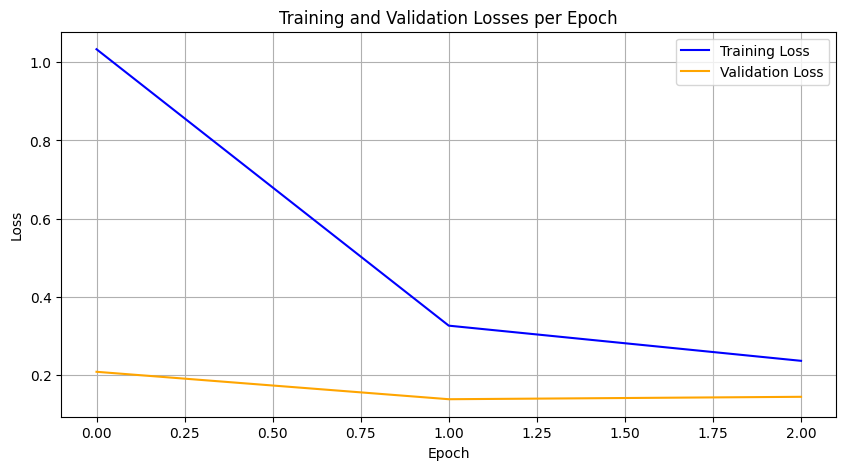

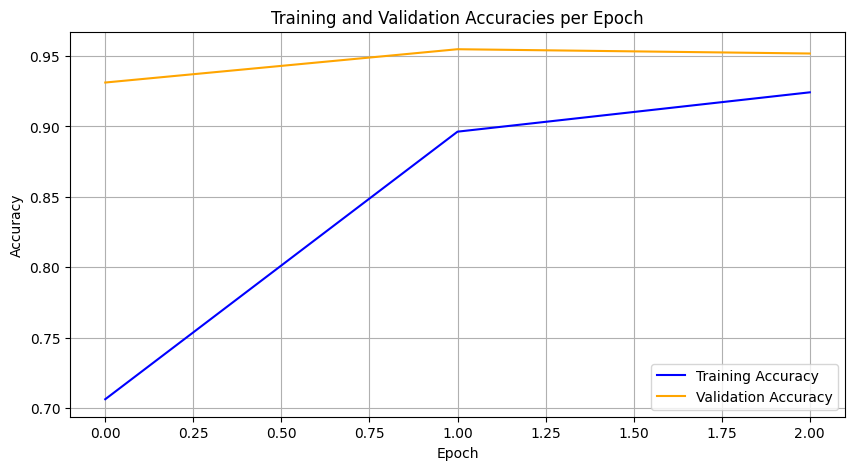

In [28]:
losses, accuracies = loss_acc
plot_losses_and_accuracies(losses, accuracies)

In [29]:
model_save_path = '/content/drive/MyDrive/Applied CV Project/best_additional_deit.pth'
torch.save(net_model.state_dict(), model_save_path)